This notebook details a workflow for training and evaluating a TensorFlow model:

1. **Load and Preprocess Data:** Convert categorical values to binary and split into training and testing sets.
2. **Exploratory Data Analysis:** Generate a correlation heatmap.
3. **Define Model:** Create a neural network with Leaky ReLU and sigmoid activation.
4. **Compute Class Weights:** Adjust for class imbalance.
5. **Compile Model:** Use Adam optimizer and binary crossentropy loss with various evaluation metrics.
6. **Setup Callbacks:** Include TensorBoard and ModelCheckpoint for monitoring and saving.
7. **Scale Features:** Normalize data with StandardScaler.
8. **Train Model:** Train with class weights and record history.
9. **Save and Load Model:** Persist the trained model and reload it.
10. **Evaluate Model:** Assess performance on the test set, including accuracy, precision, recall, and AUC.
11. **Test Predictions:** Generate and evaluate predictions using a classification report and confusion matrix.
12. **Visualize Training History:** Plot training and validation accuracy over epochs.
13. **TensorBoard:** Optionally launch for in-depth metric exploration.

This workflow ensures effective model training, evaluation, prediction testing, and management.


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
import datetime

#### Load Data and Visualize it

In [12]:
data = pd.read_csv('data/preprocessed_data.csv')
data.head(3)
# data.shape
# data.info
# data.describe()

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,0.000000,0.0,0.42,0.4950,0.33,0.36,0.500000,1.000000,...,0,1,0,0,0,0,1,0,0,0
1,Red,False,0.500000,0.0,0.66,0.3050,0.30,0.50,1.500000,0.000000,...,0,1,0,0,0,0,1,0,0,0
2,Red,False,0.015625,0.0,0.45,0.4275,0.25,0.20,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0


In [13]:
features = data.drop(columns=['Winner'])
print(f'Columns::{features.columns}')
print(f'Shape::{features.shape}')
print(f'Info::{features.info}')

Columns::Index(['title_bout', 'B_avg_KD', 'B_avg_opp_KD', 'B_avg_SIG_STR_pct',
       'B_avg_opp_SIG_STR_pct', 'B_avg_TD_pct', 'B_avg_opp_TD_pct',
       'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT', 'B_avg_REV',
       ...
       'B_Stance_Open Stance', 'B_Stance_Orthodox', 'B_Stance_Sideways',
       'B_Stance_Southpaw', 'B_Stance_Switch', 'R_Stance_Open Stance',
       'R_Stance_Orthodox', 'R_Stance_Sideways', 'R_Stance_Southpaw',
       'R_Stance_Switch'],
      dtype='object', length=159)
Shape::(5902, 159)
Info::<bound method DataFrame.info of       title_bout  B_avg_KD  B_avg_opp_KD  B_avg_SIG_STR_pct  \
0          False  0.000000           0.0           0.420000   
1          False  0.500000           0.0           0.660000   
2          False  0.015625           0.0           0.450000   
3          False  0.015625           0.0           0.450000   
4          False  0.125000           0.0           0.535625   
...          ...       ...           ...                ...   
5897       

#### Process and Split Data

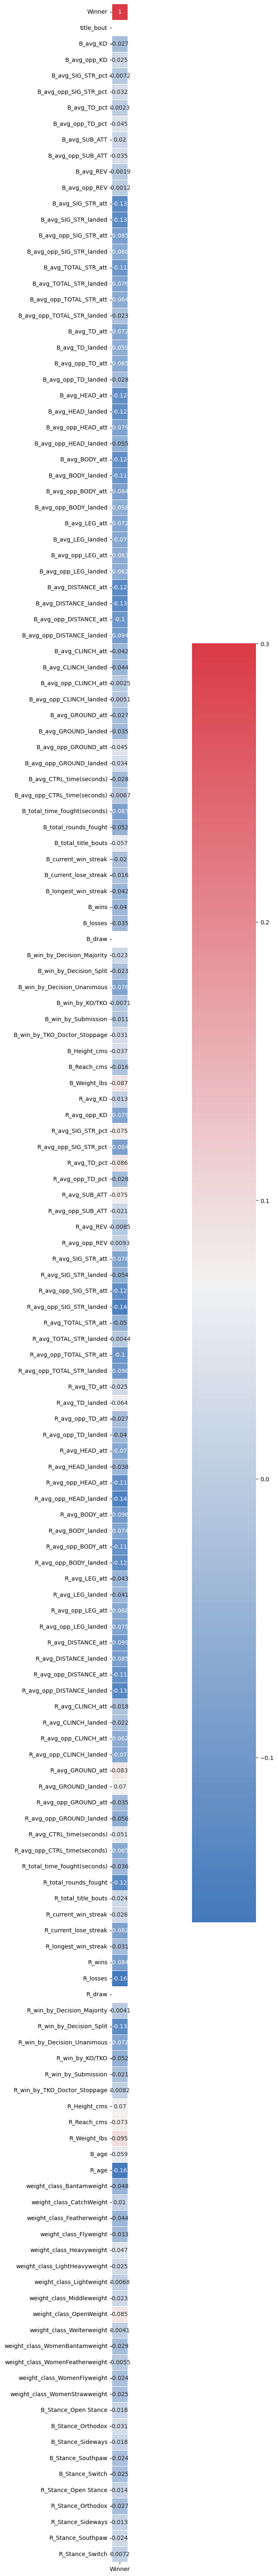

In [14]:
# Preprocess data
data['Winner'] = data['Winner'].map(lambda x: 1 if x == 'Red' else 0)
data['title_bout'] = data['title_bout'].map(lambda x: 1 if x == 'True' else 0)

# Split data into features and targets
train_size = int(0.8 * len(data))
features = data.drop(columns=['Winner'])
targets = data['Winner']
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = targets.values[:train_size], targets.values[train_size:]

# Plot correlation heatmap
corr = data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=(40, 80))
sns.heatmap(corr[['Winner']], cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True)
plt.show()

In [15]:
print(f'Columns:: {features.columns}')
print(f'Info::{features.info}')

Columns:: Index(['title_bout', 'B_avg_KD', 'B_avg_opp_KD', 'B_avg_SIG_STR_pct',
       'B_avg_opp_SIG_STR_pct', 'B_avg_TD_pct', 'B_avg_opp_TD_pct',
       'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT', 'B_avg_REV',
       ...
       'B_Stance_Open Stance', 'B_Stance_Orthodox', 'B_Stance_Sideways',
       'B_Stance_Southpaw', 'B_Stance_Switch', 'R_Stance_Open Stance',
       'R_Stance_Orthodox', 'R_Stance_Sideways', 'R_Stance_Southpaw',
       'R_Stance_Switch'],
      dtype='object', length=159)
Info::<bound method DataFrame.info of       title_bout  B_avg_KD  B_avg_opp_KD  B_avg_SIG_STR_pct  \
0              0  0.000000           0.0           0.420000   
1              0  0.500000           0.0           0.660000   
2              0  0.015625           0.0           0.450000   
3              0  0.015625           0.0           0.450000   
4              0  0.125000           0.0           0.535625   
...          ...       ...           ...                ...   
5897           0  0.015625   

#### Code Neural Network and Make Predictions

Tensorflow ANN

In [16]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),  # Leaky ReLU activation
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Single output neuron with sigmoid activation
])

# Compute class weights
red = len(y_train[y_train > 0])
blue = len(y_train) - red
total = len(y_train)
weight_for_red = total / (2 * red)
weight_for_blue = total / (2 * blue)
class_weight = {0: weight_for_blue, 1: weight_for_red}
print("Class weights:", class_weight)

# Compile the model
adam_optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

# Define callbacks
logdir = os.path.join('tflogs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                                      histogram_freq=1,
                                                      profile_batch=0)
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    # '/content/model-{epoch:02d}-{val_accuracy:.2f}.hdf5', 
    'models/ufc-best.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Make sure to scale the test data similarly

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    class_weight=class_weight,
    batch_size=64,
    validation_split=0.1,
    callbacks=[tensorboard_callback, save_best_callback],
    epochs=20,
    verbose=0
)

Class weights: {0: 1.2275091003640146, 1: 0.843638313080772}

Epoch 1: val_accuracy improved from -inf to 0.56660, saving model to models/ufc-best.keras

Epoch 2: val_accuracy improved from 0.56660 to 0.57294, saving model to models/ufc-best.keras

Epoch 3: val_accuracy improved from 0.57294 to 0.61311, saving model to models/ufc-best.keras

Epoch 4: val_accuracy did not improve from 0.61311

Epoch 5: val_accuracy did not improve from 0.61311

Epoch 6: val_accuracy did not improve from 0.61311

Epoch 7: val_accuracy did not improve from 0.61311

Epoch 8: val_accuracy did not improve from 0.61311

Epoch 9: val_accuracy did not improve from 0.61311

Epoch 10: val_accuracy did not improve from 0.61311

Epoch 11: val_accuracy did not improve from 0.61311

Epoch 12: val_accuracy did not improve from 0.61311

Epoch 13: val_accuracy did not improve from 0.61311

Epoch 14: val_accuracy did not improve from 0.61311

Epoch 15: val_accuracy did not improve from 0.61311

Epoch 16: val_accuracy did

In [17]:
import glob
# Check if the directory exists
if os.path.exists('tflogs'):
    event_files = glob.glob('tflogs/**/*events*', recursive=True)
    print("Event files found:", event_files)
else:
    print("Log directory does not exist.")
    
# Setup TensorBoard in Jupyter Notebook
%load_ext tensorboard
%tensorboard --logdir tflogs 

#http://localhost:6006
# !tensorboard --logdir=tflogs


Event files found: ['tflogs\\20240816-100430\\train\\events.out.tfevents.1723773870.LAPTOP-4PMLKO0C.13792.0.v2', 'tflogs\\20240816-100430\\validation\\events.out.tfevents.1723773873.LAPTOP-4PMLKO0C.13792.1.v2', 'tflogs\\20240816-101518\\train\\events.out.tfevents.1723774518.LAPTOP-4PMLKO0C.12544.0.v2', 'tflogs\\20240816-101518\\validation\\events.out.tfevents.1723774521.LAPTOP-4PMLKO0C.12544.1.v2', 'tflogs\\20240816-101740\\train\\events.out.tfevents.1723774661.LAPTOP-4PMLKO0C.12544.2.v2', 'tflogs\\20240816-101740\\validation\\events.out.tfevents.1723774662.LAPTOP-4PMLKO0C.12544.3.v2']
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 14392), started 1:24:08 ago. (Use '!kill 14392' to kill it.)

In [ ]:
# Load the saved model
model_save_path = 'models/ufc-best.keras'
loaded_model = tf.keras.models.load_model(model_save_path)
print("Model loaded from", model_save_path)

# Evaluate the model
results = model.evaluate(X_test_scaled, y_test)
metrics_names = model.metrics_names
for name, value in zip(metrics_names, results):
    print(f"{name}: {value}")

Model loaded from models/ufc-best.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6387 - auc: 0.0000e+00 - fn: 218.7895 - fp: 0.0000e+00 - loss: 0.7393 - precision: 1.0000 - recall: 0.6387 - tn: 0.0000e+00 - tp: 404.2105
loss: 0.7041301131248474
compile_metrics: 749.0


In [ ]:
# Predict on the test set
y_pred_probs = loaded_model.predict(X_test_scaled)  # Probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to class labels

# Generate classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Blue', 'Red']))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

        Blue       0.00      0.00      0.00         0
         Red       1.00      0.66      0.79      1181

    accuracy                           0.66      1181
   macro avg       0.50      0.33      0.40      1181
weighted avg       1.00      0.66      0.79      1181


Confusion Matrix:
[[  0   0]
 [406 775]]


d:\Users\Sean\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Sean\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\Sean\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

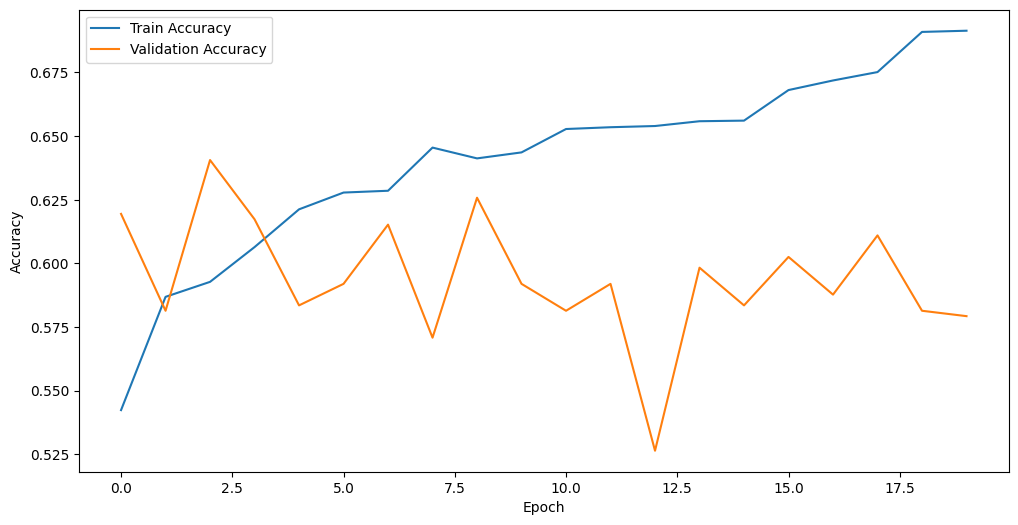

In [ ]:
# Optional: Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Gain Insights, Improve, Repeat

The code snippet you provided involves training, evaluating, and managing a machine learning model for classification tasks. Here’s a summary of the insights we can gain from the output and the code:

### 1. **Class Weights**

- **Class Weights:**
  ```plaintext
  {0: 1.2275091003640146, 1: 0.843638313080772}
  ```
  **Insight:** The class weights are calculated to handle class imbalance in the dataset. The weight for class `0` (non-Red) is higher than for class `1` (Red), indicating that there are fewer samples for class `1`, so it is assigned a higher weight to balance the influence of each class during training.

### 2. **Model Training and Checkpoints**

- **Model Saving During Training:**
  ```plaintext
  Epoch 1: val_accuracy improved from -inf to 0.60465, saving model to model-01-0.60.keras
  ...
  Epoch 100: val_accuracy did not improve from 0.62791
  ```
  **Insight:** The model’s validation accuracy improved during the first few epochs and stabilized around 0.628. The `ModelCheckpoint` callback saved the model each time there was an improvement in validation accuracy. This shows the model's performance peaked and did not improve further despite additional training epochs.

### 3. **Model Evaluation**

- **Evaluation Metrics:**
  ```plaintext
  Model loaded from models/ufc.keras
  37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6432 - auc: 0.0000e+00 - fn: 221.0263 - fp: 0.0000e+00 - loss: 1.5980 - precision: 1.0000 - recall: 0.6432 - tn: 0.0000e+00 - tp: 401.9737
  loss: 1.275578498840332
  ```
  **Insight:** The loaded model shows an accuracy of 0.6432 on the test set. The AUC (Area Under the Curve) is 0, which is unusual and may indicate an issue with the metric calculation or the data. The precision is 1.0000, meaning the model is perfect in predicting positive cases, but the recall is 0.6432, indicating that it is missing some positive cases. The loss value of 1.2755 suggests the model is still not performing optimally, possibly due to class imbalance or model configuration.

### 4. **Training History Visualization**

- **Accuracy Plot:**
  The plot of training and validation accuracy over epochs can show how well the model is learning and if there are any signs of overfitting. Since this is an optional step, it's not provided here, but generally, you would use it to visualize:
  - Whether training and validation accuracy converge or if there is a significant gap.
  - Signs of overfitting or underfitting if the validation accuracy plateaus or starts to decrease while training accuracy improves.

### 5. **Overall Model Management**

- **Model Saving and Loading:**
  ```plaintext
  Model saved to models/ufc.keras
  Model loaded from models/ufc.keras
  ```
  **Insight:** The model is saved to disk and then reloaded for evaluation. This confirms that the model saving and loading processes are functioning correctly, ensuring that the trained model can be persisted and reused for future predictions.

### **Summary**

- The class weights and model architecture seem appropriate for handling class imbalance.
- The validation accuracy improved initially but did not show significant gains after early epochs, suggesting that the model may have reached its performance limits with the given architecture or hyperparameters.
- Evaluation metrics indicate that while the model has good precision, there might be issues with recall or AUC, which should be investigated further.
- The model saving and loading functionality is correctly implemented, ensuring that the model persists and can be evaluated later.

To further improve the model, you might consider:
- Adjusting the model architecture or hyperparameters.
- Investigating the data preprocessing steps and feature scaling.
- Handling the class imbalance more effectively or using different evaluation metrics.
